## Testing vistan against the Toy-Example

We need an old version of pystan.

In [17]:
!pip install pystan==2.19.1.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 75 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


In [18]:
!pip install vistan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
x = [
      [1.3709584 , 1.48475156],
      [-0.5646982, -1.42449894],
      [0.3631284,  0.10432308],
      [0.6328626,  0.27923186],
      [0.4042683,  0.09138635],
      [-0.1061245, -0.53519391]
]
y = [-1.46778013, -0.09421285, -0.41162052, -0.31177232, -0.52569912, -1.22375575]
data = {"P":2, "N":6, "x":x, "y":y}

data

{'N': 6,
 'P': 2,
 'x': [[1.3709584, 1.48475156],
  [-0.5646982, -1.42449894],
  [0.3631284, 0.10432308],
  [0.6328626, 0.27923186],
  [0.4042683, 0.09138635],
  [-0.1061245, -0.53519391]],
 'y': [-1.46778013,
  -0.09421285,
  -0.41162052,
  -0.31177232,
  -0.52569912,
  -1.22375575]}

In [20]:
import vistan 

In [30]:
import vistan 
import matplotlib.pyplot as plt
import numpy as np 
import scipy
code = """
data {
  int<lower=0> N;
  int<lower=1> P;
  vector[N] y;
  matrix[N,P] x;
}

parameters {
  vector[P] w;
  real b;
  real<lower=0> sigma;
}

model {
  y ~ normal(x * w + b, sigma);
  b ~ normal(0,10);
  w ~ normal(0, 10);
  sigma ~ lognormal(0.5,1);
}

generated quantities {
  real log_prior = normal_lpdf(b | 0, 10) + normal_lpdf(w |0, 10)  + lognormal_lpdf(sigma| 0.5, 1);
  real log_likelihood = normal_lpdf(y | x * w + b, sigma);
}
"""

algo = vistan.recipe() # runs Meanfield VI by default
#algo = vistan.recipe("flows")  #Runs Flow see https://github.com/abhiagwl/vistan
posterior = algo(code, data) 
samples = posterior.sample(100000)

Compiled model found.
Starting optimization.


Optimizing via full-step-search|          |  0%|0/3[00:00<?]

Selected parameters with mean ELBO trace: -12.3381


In [31]:
samples.keys()

odict_keys(['w', 'b', 'sigma', 'log_prior', 'log_likelihood'])

In [32]:
qs = posterior.log_prob(samples)

            log_prob function returns the log density of the
            unconstrained base q distribution used during optimization.
            If you trained with M_iw_train > 1, then this is different
            than the log_prob of the posterior.

            Please, see https://arxiv.org/pdf/1808.09034 for more details.
            


In [24]:
%load_ext rpy2.ipython

In [25]:
%%R 
warn = getOption("warn")
options(warn=-1)
install.packages('loo')
options(warn=warn)
library(loo)

(as ‘lib’ is unspecified)



















	‘/tmp/Rtmp9o2TBr/downloaded_packages’






In [26]:
log_prior = samples['log_prior']
log_likelihood = samples['log_likelihood']

In [27]:
%%R -i log_prior -i qs -i log_likelihood
str(log_prior)
str(log_likelihood)
str(qs)
log_ratios = as.vector(log_prior + log_likelihood - qs)
dd=psis(log_ratios)
cat(
    #We compare against the R-implemetation (for MF-Gaussian) in which the likelihoods have been calculated by 'Hand' 
    mean(qs), #In the R-implementation -4.049542
    mean(log_likelihood), #In the R-implementation -9.014094
    mean(log_prior), #In the R-implementation  -10.88847
    dd$diagnostics$pareto_k #0.9532935
)

 num [1:100000(1d)] -10.8 -10.8 -11.1 -10.7 -11.3 ...
 num [1:100000(1d)] -7.3 -6.95 -9.61 -3.94 -9.83 ...
 num [1:100000(1d)] -3.53 -2.68 -3.17 -4.85 -3.7 ...
-4.065428 -8.353728 -10.8854 0.8760786

In [ ]:
w = samples['w'] 

           [,1]       [,2]
[1,]  1.0000000 -0.3847091
[2,] -0.3847091  1.0000000


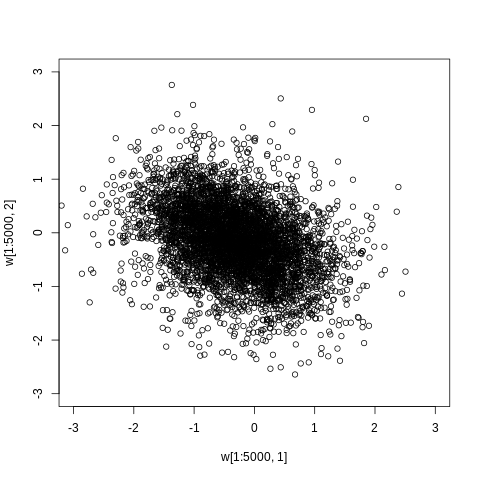

In [ ]:
%%R -i w
plot(w[1:5000,1], w[1:5000,2], xlim=c(-3,3), ylim=c(-3,3))
cor(w)

### Write out the samples

In [34]:
import pandas as pd
w_df = pd.DataFrame(data=samples['w'], columns=['w1', 'w2'])
#df.to_csv('2D_flow_w_samples.csv.gz', compression='gzip', index=False)
w_df.to_csv('2D_MFG_w_samples.csv.gz', compression='gzip', index=False)

In [ ]:
i_df = pd.DataFrame(data=samples['b'], columns=['b'])
#df.to_csv('2D_flow_intercept_samples.csv.gz', compression='gzip', index=False)
i_df.to_csv('2D_MFG_intercept_samples.csv.gz', compression='gzip', index=False)

In [ ]:
s_df = pd.DataFrame(data=samples['sigma'], columns=['b'])
#df.to_csv('2D_flow_sigma_samples.csv.gz', compression='gzip', index=False)
s_df.to_csv('2D_MFG_sigma_samples.csv.gz', compression='gzip', index=False)

In [ ]:
qs_df = pd.DataFrame(data=qs, columns=['qs'])
#df.to_csv('2D_flow_qs_samples.csv.gz', compression='gzip', index=False)
qs_df.to_csv('2D_MFG_qs_samples.csv.gz', compression='gzip', index=False)

In [40]:
joint_df = pd.DataFrame(data=samples['log_likelihood'] + samples['log_prior'], columns=['log_joint'])
joint_df.to_csv('2D_MFG_log_joints_samples.csv.gz', compression='gzip', index=False)